План занятия:

Рассматриваем несколько архитектур
* AlexNet
* VGG
* Inception
* ResNet

Перенос обучения


### LeNet

На пролом занятии мы познакомились с самой первой сверточной архитектурой LeNet, которая решала вполне неплохо задачу классификации на датасете MNIST. Но есть намного более интересные задачи по классификации изображений.

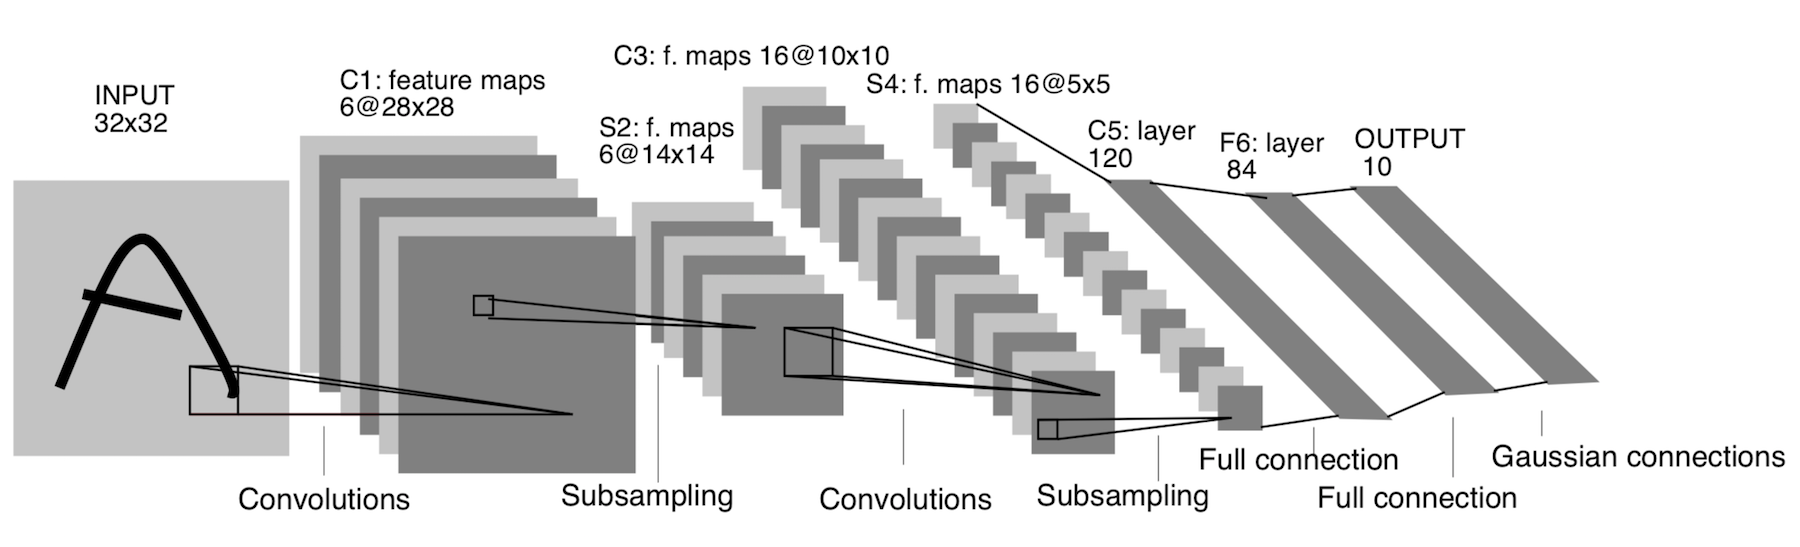

### Датасет ImageNet

[ImageNet](https://image-net.org/) — набор из 15 миллионов помеченных изображений с высоким разрешением, разделенных на 22 000 категорий. Изображения собраны в интернете и помечены вручную с помощью краудсорсинга.

В 2010 году, как часть Pascal Visual Object Challenge, началось ежегодное соревнование — ImageNet Large-Scale Visual Recognition Challenge (ILSVRC). В ILSVRC используется подвыборка из ImageNet размером 1000 изображений в каждой из 1000 категорий. Таким образом, тренировочный сет состоял из примерно 1.2 миллионов изображений, проверочный — 50000 изображений, тестовый — 150000 изображений. Так как ImageNet состоит из изображений разного размера, то их необходимо было привести к единому размеру 256х256. Если изображение представляет из себя прямоугольник, то оно масштабируется и из него вырезается центральная часть размером 256х256.

### AlexNet

AlexNet — сверточная нейронная сеть, которая оказала большое влияние на развитие машинного обучения, в особенности — на алгоритмы компьютерного зрения. Сеть с большим отрывом выиграла конкурс по распознаванию изображений ImageNet LSVRC-2012 в 2012 году (с количеством ошибок 15,3% против 26,2% у второго места).


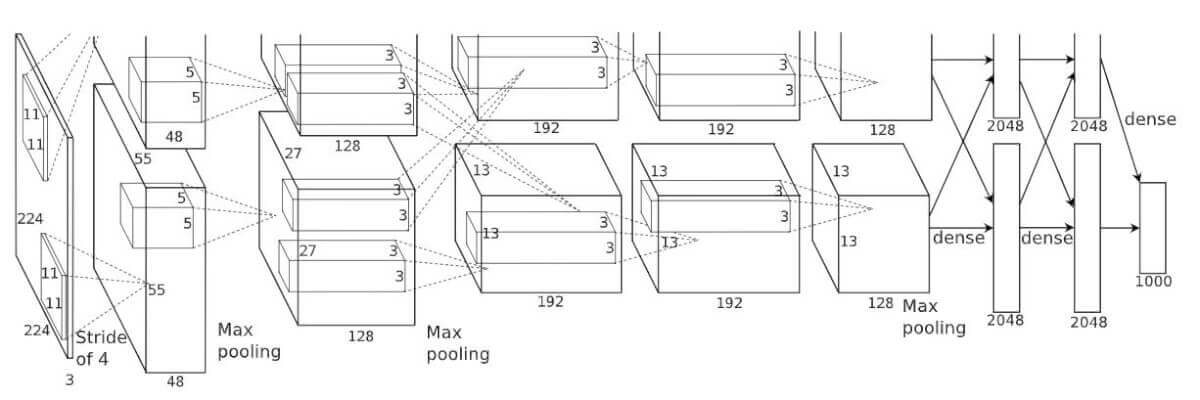

На изображении выше можно заметить, что архитектура выглядит довольно запутанной. Все дело в том, что для ее обучения использовались две видеокарты и сеть именно таким образом была размещена на них. Более привычно можно представить архитектуру в таком виде:

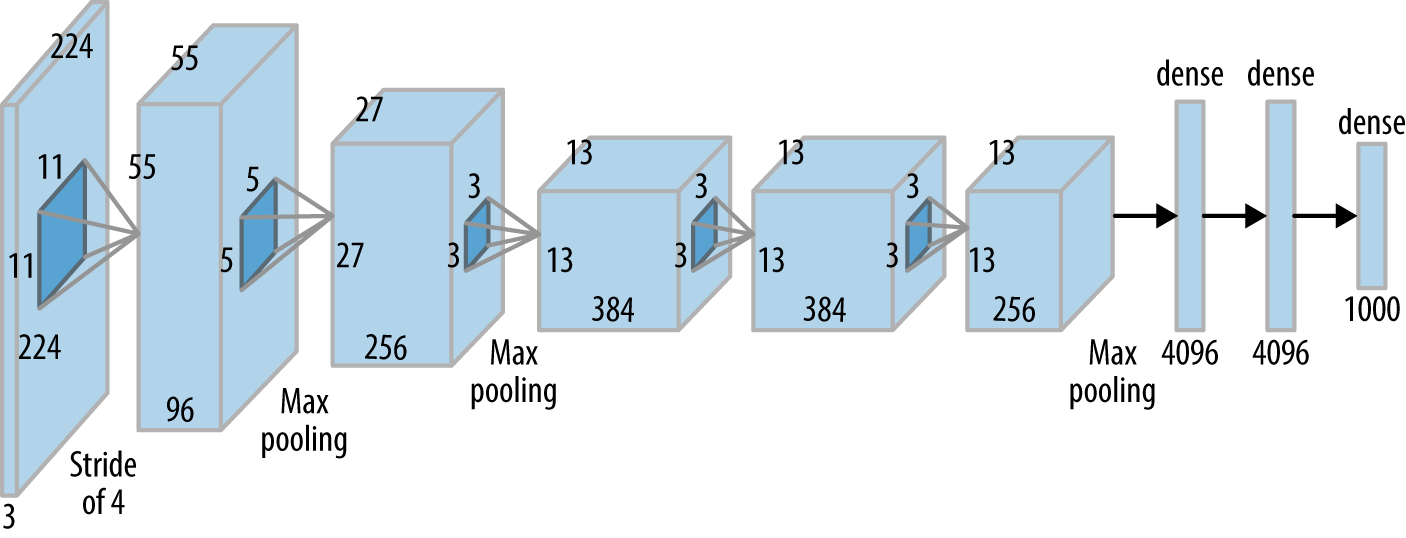

AlexNet содержит 5 сверточных слоев и 3 полносвязных слоя. Relu применяется после каждого сверточного и полносвязного слоя. Дропаут применяется перед первым и вторым полносвязными слоями. 

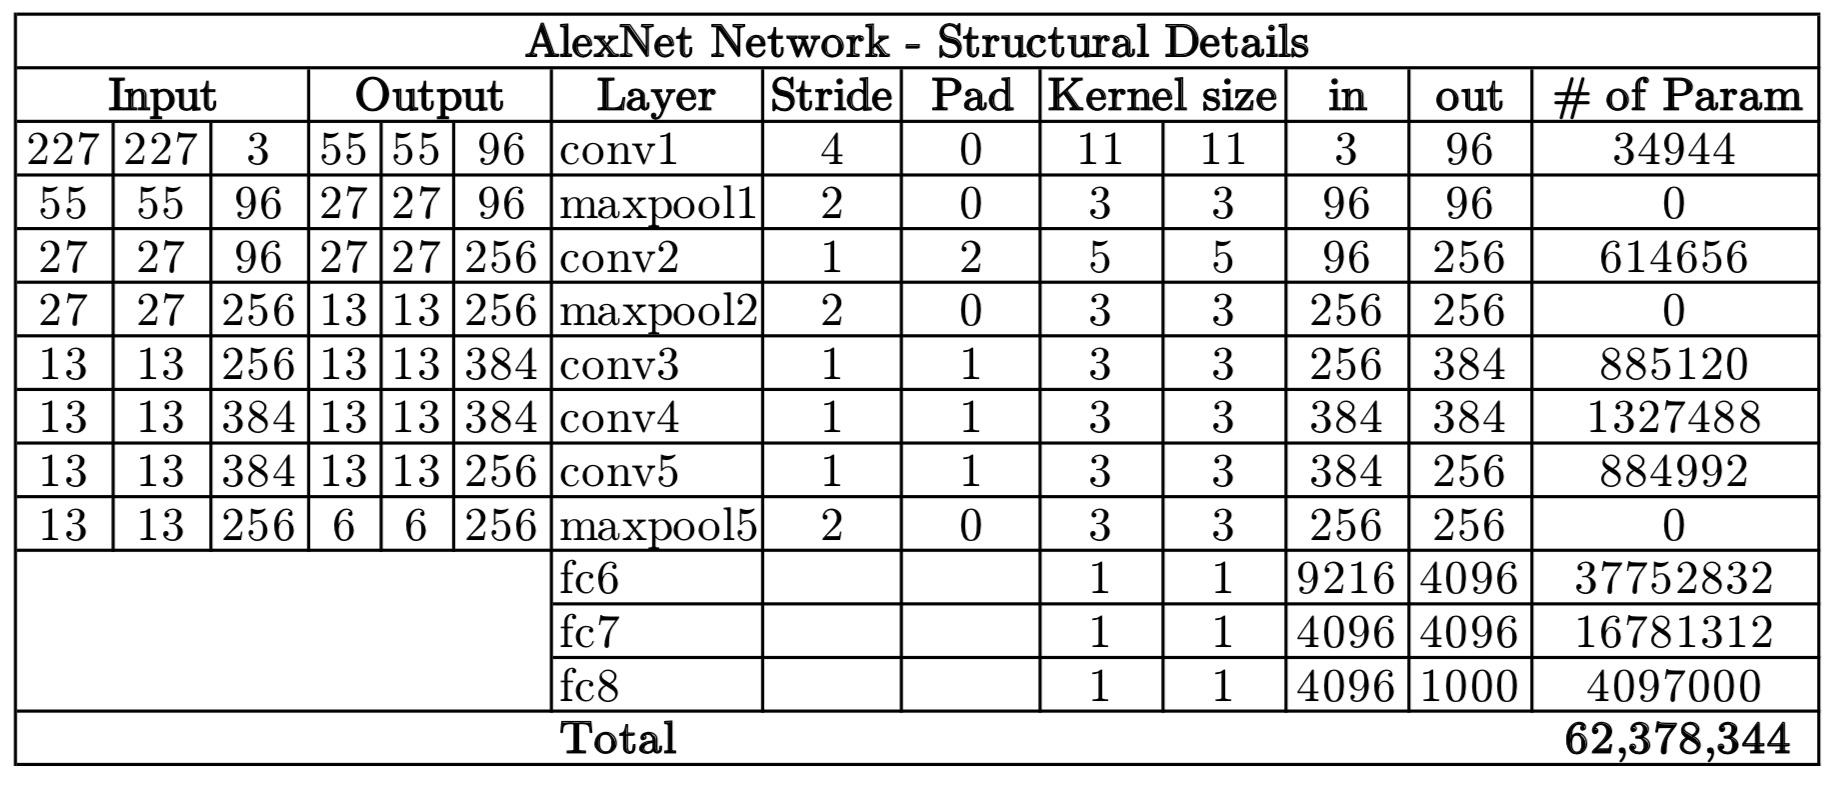

Входом в сеть является пакет изображений RGB размером 227x227x3, который выдает вектор вероятности 1000x1, соответствующий каждому классу.

В чем основные новшества:
* Используется аугментация данных (флипы и кропы)
* Сеть использует перекрывающиеся maxpooling слои после первого, второго и пятого сверточного слоя. Перекрытые слои maxpool - это просто слои maxpool с шагом меньше размера окна. Слой maxpool 3x3 используется с шагом 2, что создает перекрывающиеся рецептивные поля. 
* Использование Relu вместо гиперболического тангенса и сигмоид. За счет этого при одинаковой точности метода скорость становится в 6 раз быстрее.
* Использование дропаута с вероятностью 0.5 для регуляризации.



Реализация модели на [PyTorch](https://github.com/pytorch/vision/blob/main/torchvision/models/alexnet.py) немного отличается от оригинальной статьи.

In [ ]:

class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

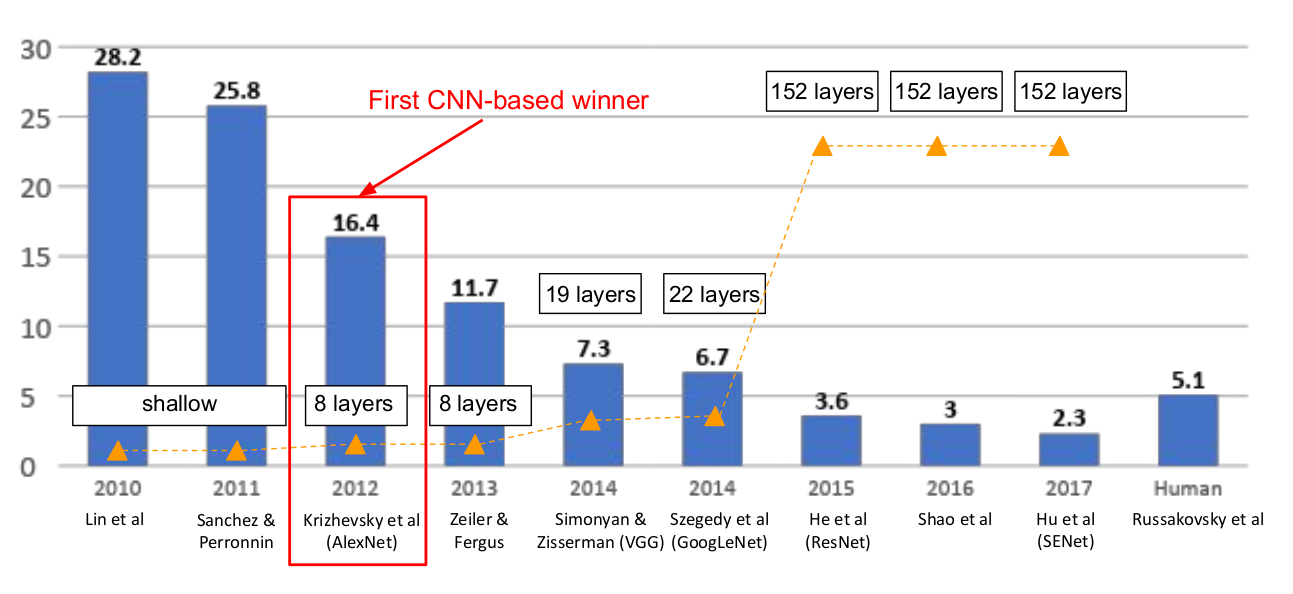

### VGG

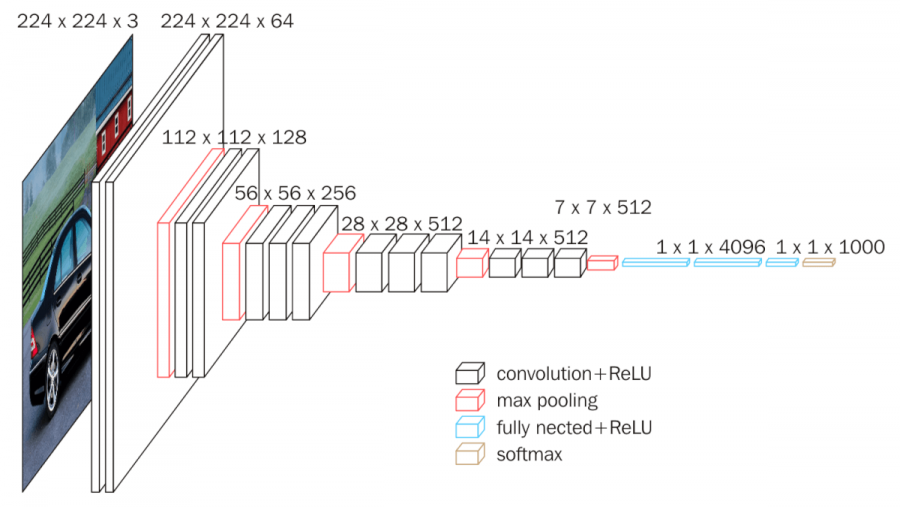

Сравним с AlexNet:

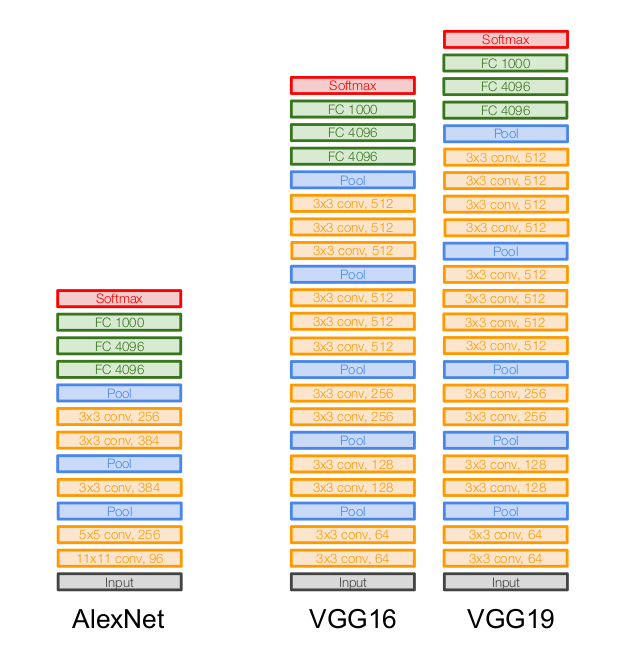

Конфигурации сетей представлены в таблице ниже. 
Каждая сеть соответствует своему имени (A-E). Все конфигурации имеют общую конструкцию, представленную в архитектуре, и различаются только глубиной: от 11 слоев с весами в сети A (8 сверточных и 3 полносвязных слоя) до 19 (16 сверточных и 3 полносвязных слоя). Ширина сверточных слоев (количество каналов) относительно небольшая: от 64 в первом слое до 512 в последнем с увеличением количества каналов в 2 раза после каждого max-pooling слоя.

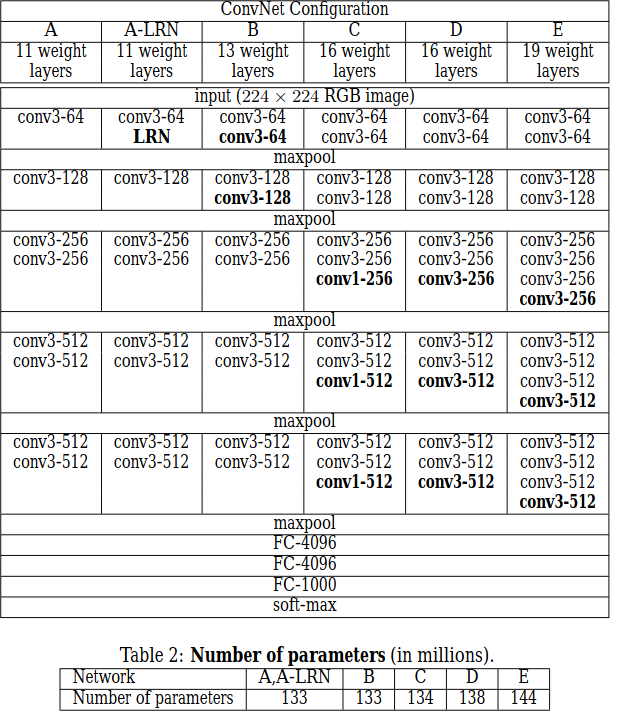

В чем новшества по сравнению с предыдущими подходами?

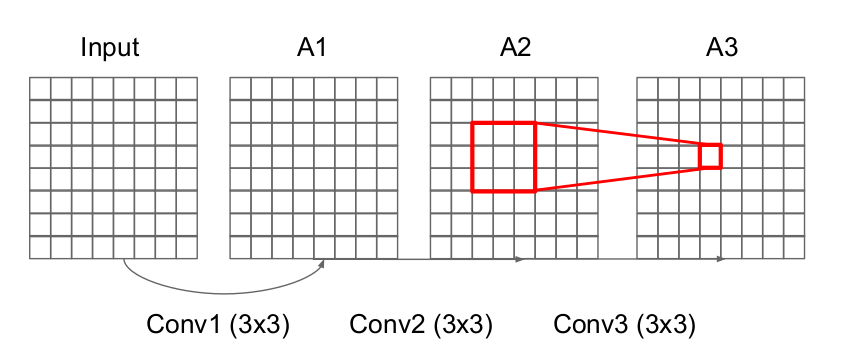

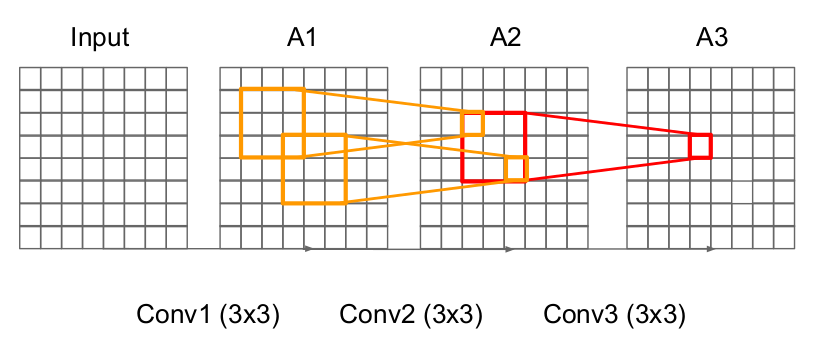

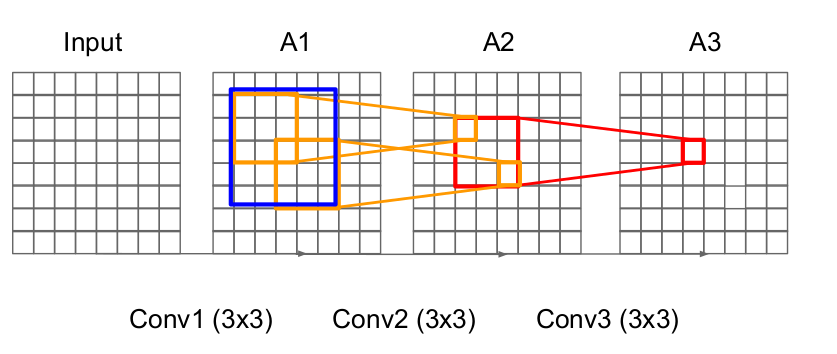

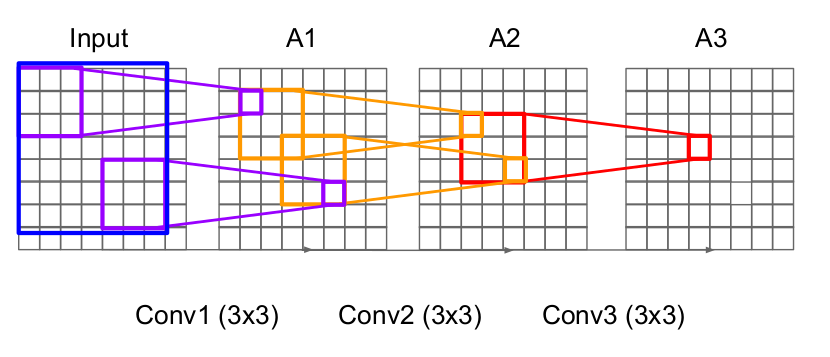

Три сверточных слоя с размером сверток 3х3 обладают таким же по размеру рецептивным полем, как и одна свертка 7х7, но при этом у нас уменьшается количество параметров:

для маленьких сверток: $3 * (3^2 *C^2) $

для сверток 7х7: $7^2 * C^2$

**Недостатки**:


* Очень медленная скорость обучения.
* Сама архитектура сети весит слишком много


Реализация модели на [PyTorch](https://github.com/pytorch/vision/blob/main/torchvision/models/vgg.py).

### GoogLeNet

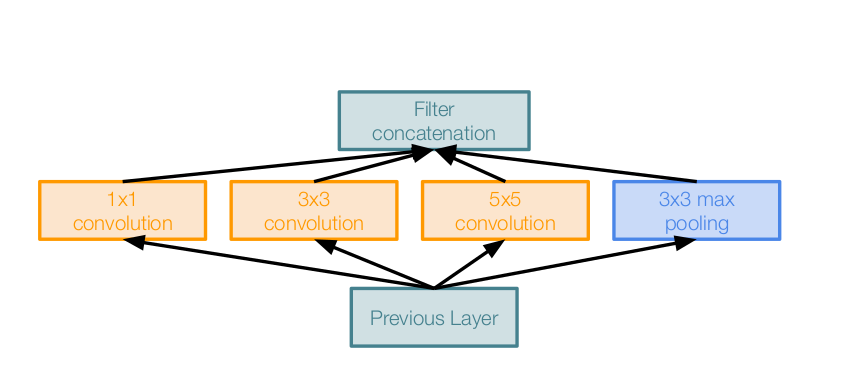

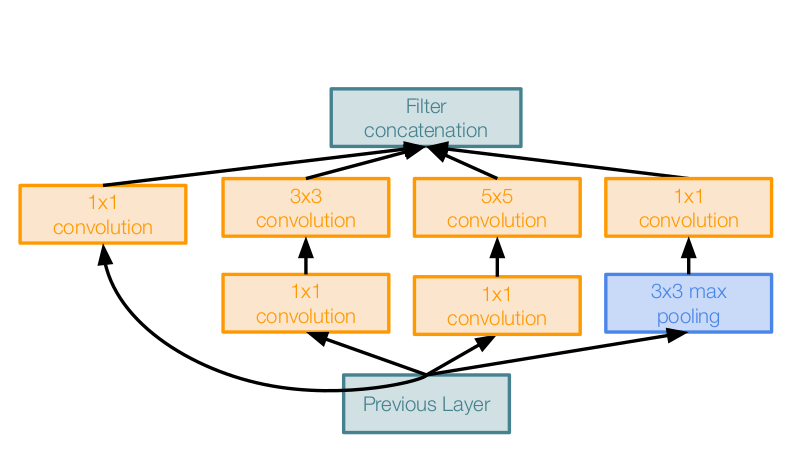

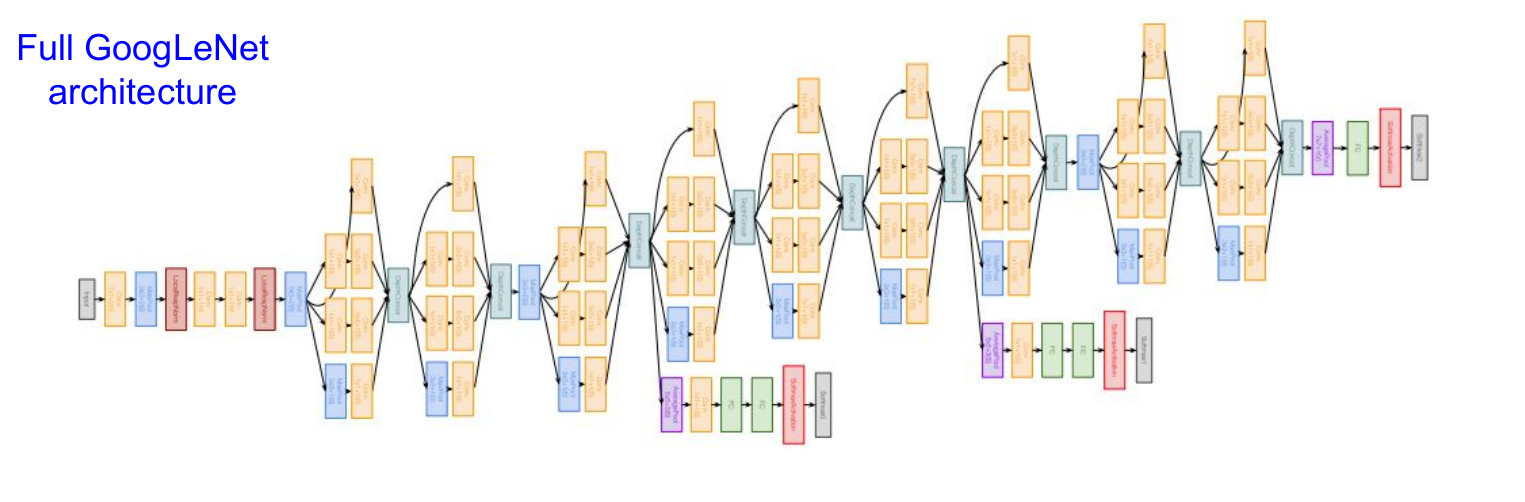

[Реализация](https://github.com/pytorch/vision/blob/main/torchvision/models/googlenet.py) в PyTorch.

Отличительные особенности:
* 22 слоя
* Эффективная ячейка“Inception” 
* Уменьшение использования неповоротливых полносвязных слоев
* В 12 раз меньше параметров, чем у AlexNet
* В 27 раз меньше параметров, чем у  VGG-16

### ResNet

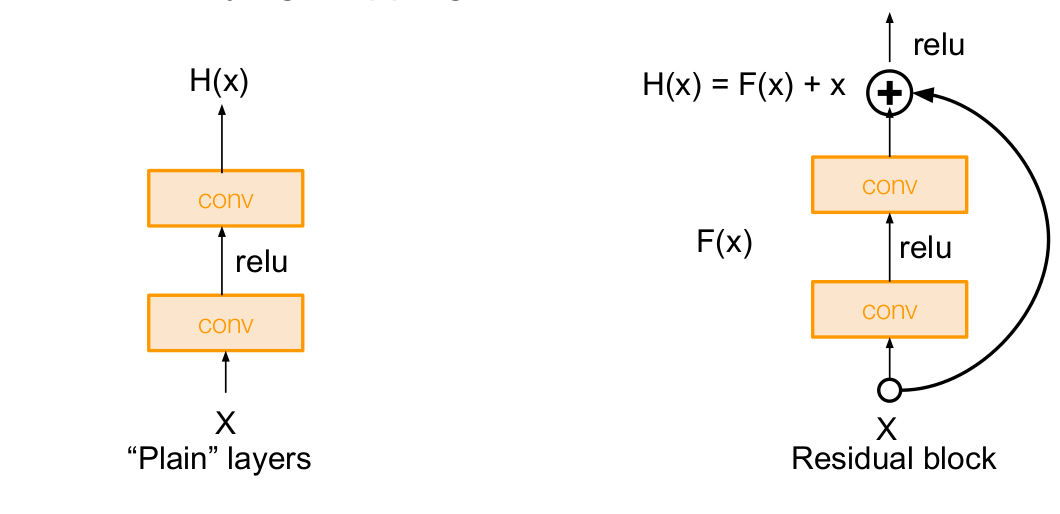

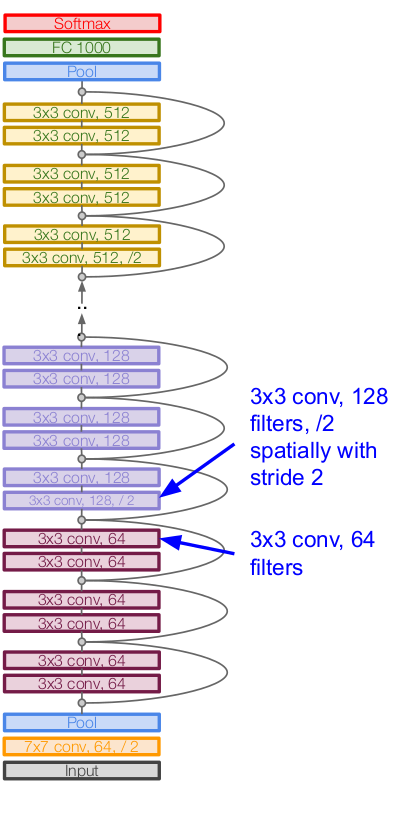

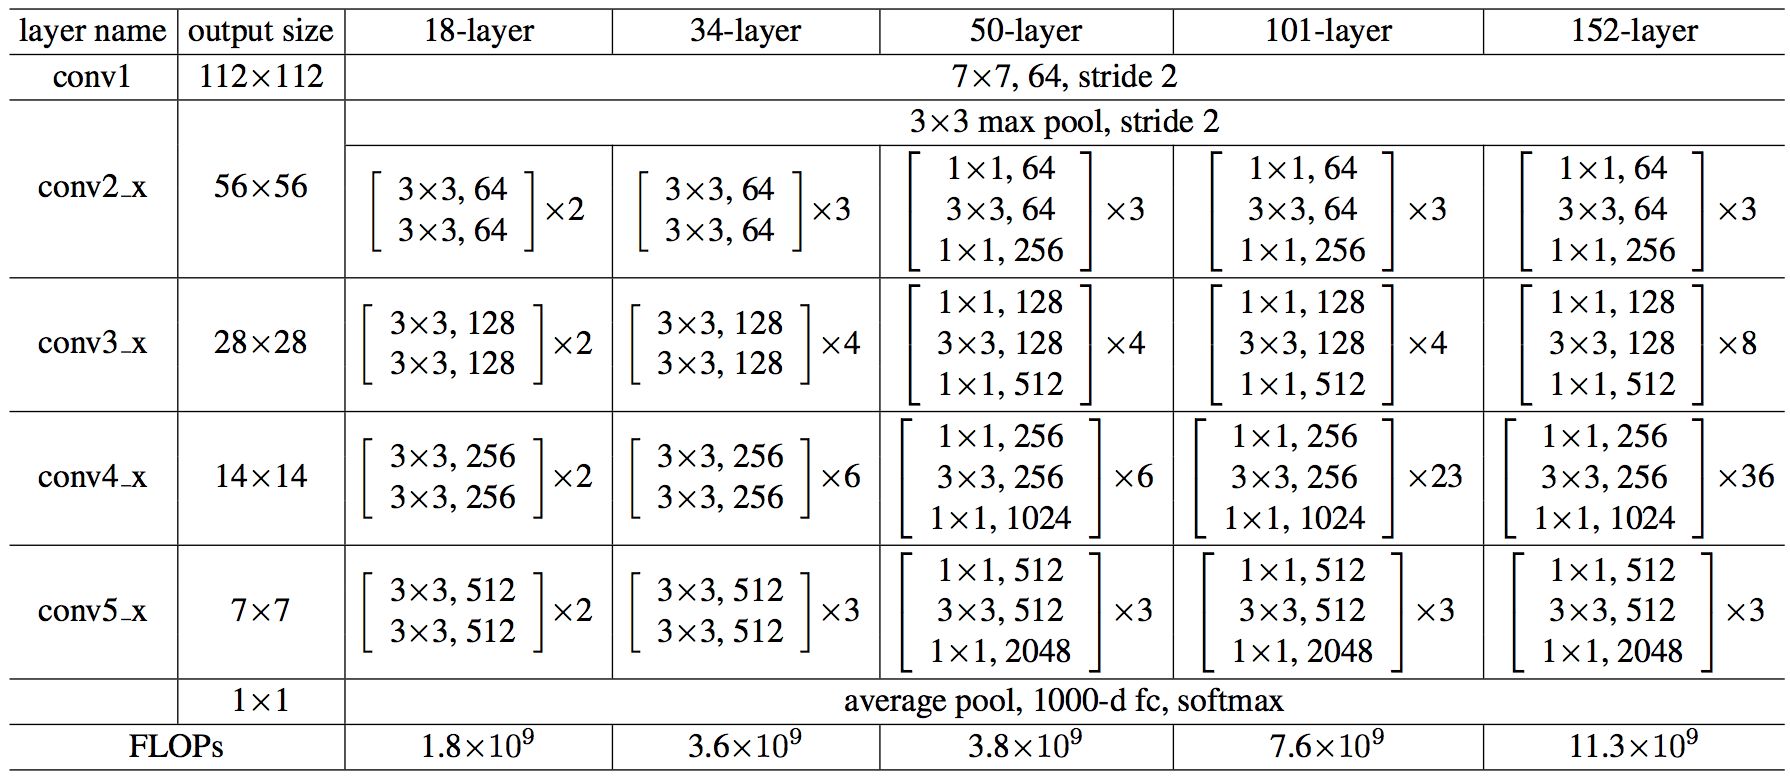

[Реализация](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py) в PyTorch.

## Transfer Learning

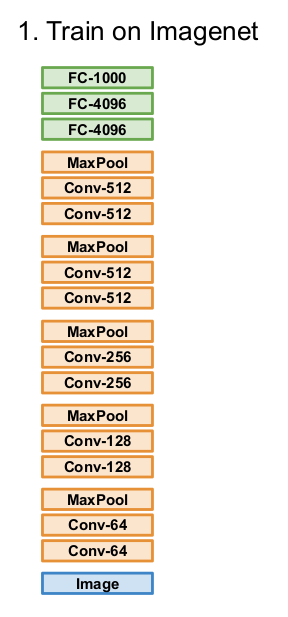

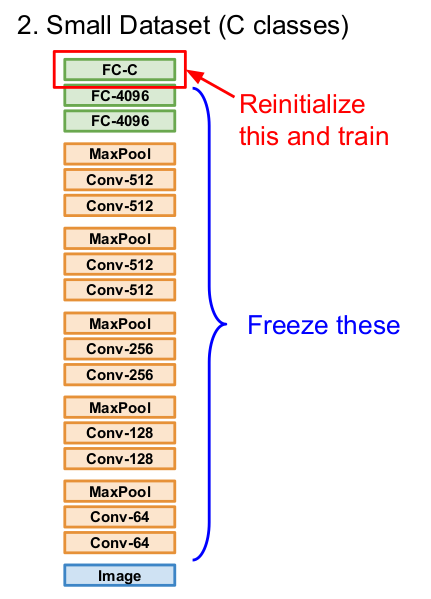

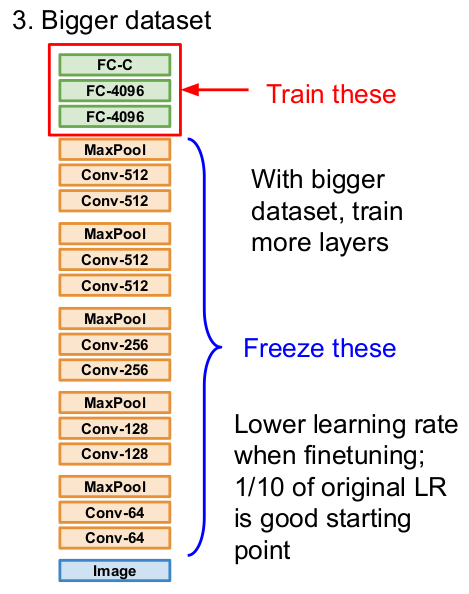

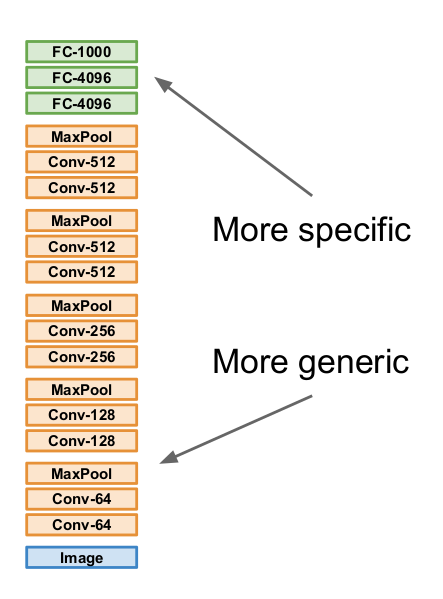

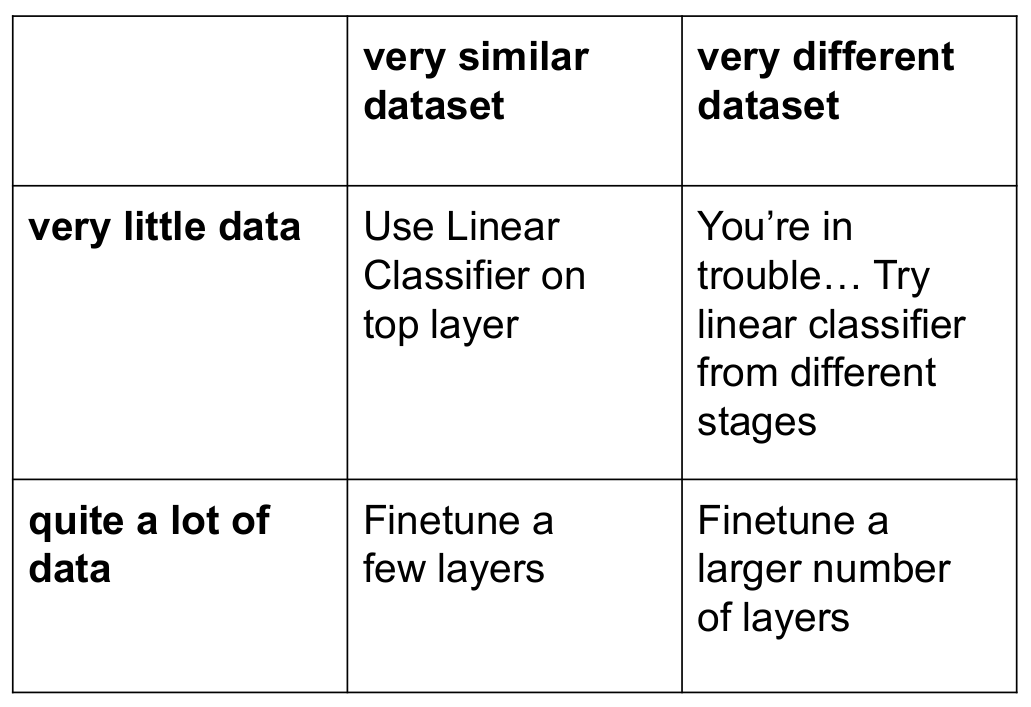

In [34]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms




In [2]:
%load_ext tensorboard

In [ ]:
! wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
! unzip hymenoptera_data.zip

In [4]:
train_transforms = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

In [5]:
path_to_data = 'hymenoptera_data'

label_map = {
    0 : 'ants',
    1: 'bees'
}

training_data = datasets.ImageFolder(
    os.path.join(path_to_data, 'train'),
    transform=train_transforms
)

test_data = datasets.ImageFolder(
    os.path.join(path_to_data, 'val'),
    transform=test_transforms
)


In [6]:
batch_size = 8

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [7]:
def imshow(img):
    plt.figure(figsize=(16, 4))
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(test_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out)


In [ ]:
model = models.resnet18(pretrained=True)

In [ ]:
model

In [11]:
number_of_features = model.fc.in_features
print(number_of_features)

512


In [12]:
model.fc = nn.Linear(number_of_features, 2)

In [ ]:
model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
model.to(device)

In [21]:
learning_rate = 0.001
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [22]:
loss_fn = nn.CrossEntropyLoss()

In [23]:
def train_loop(dataloader, model, loss_fn, optimizer, epoch_n, device, summary_writer):
    len_of_dataset = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    num_batches = len(dataloader)

    train_loss, train_accuracy = 0, 0
    model.train()
    with tqdm(dataloader, unit='batch') as tepoch:
        for images, labels in tepoch:

            # Определяем описание для tqdm
            tepoch.set_description(f'Epoch {epoch_n}')

            images, labels = images.to(device), labels.to(device)
            # Делаем forward pass
            pred = model(images)
            # вычисляем loss
            loss = loss_fn(pred, labels)

            # Вычисляем градиенты
            optimizer.zero_grad()
            loss.backward()

            # Делаем шаг оптимизатора
            optimizer.step()

            # Вычисляем количество правильных ответов
            correct = (pred.argmax(1) == labels).sum().item()
            accuracy = correct / batch_size

            # Прибавляем loss и accuracy к полным значениям за эпоху
            train_loss += loss.item()
            train_accuracy += correct
            # Выводим в tqdm текущие лосс и точность
            tepoch.set_postfix(loss=loss.item(), accuracy=accuracy)

    # вычисляем среднее
    train_loss /= num_batches
    train_accuracy /= len_of_dataset

    # Записываем в тензорборд
    summary_writer.add_scalar(
        'train/loss',
        train_loss,
        epoch_n
    )

    summary_writer.add_scalar(
        'train/accuracy',
        train_accuracy,
        epoch_n
    )


In [24]:
def test_loop(dataloader, model, loss_fn, epoch_n,  device, summary_writer):
    len_of_dataset = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
    # На этапе валидации нам не нужно вычислять градиенты
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            pred = model(images)
            test_loss += loss_fn(pred, labels).item()
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= len_of_dataset

    summary_writer.add_scalar(
        'test/loss',
        test_loss,
        epoch_n
    )

    summary_writer.add_scalar(
        'test/accuracy',
        correct,
        epoch_n
    )
    print(f'Test Metrics: \n Accuracy: {(correct):>0.3f}, Avg loss: {test_loss:>8f} \n')

In [ ]:
num_of_epochs = 10

writer = SummaryWriter('runs/resnet_ft')


for epoch_n in range(num_of_epochs):
    train_loop(train_dataloader, model, loss_fn, optimizer, num_of_epochs, device, writer)
    test_loop(test_dataloader, model, loss_fn, num_of_epochs, device, writer)

writer.close()
print("Done!")

In [28]:
model_freeze_conv = torchvision.models.resnet18(pretrained=True)
for param in model_freeze_conv.parameters():
    param.requires_grad = False

number_of_features = model_freeze_conv.fc.in_features

model_freeze_conv.fc = nn.Linear(number_of_features, 2)

model_freeze_conv = model_freeze_conv.to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_freeze_conv.fc.parameters(), lr=0.001, momentum=0.9)

In [ ]:
num_of_epochs = 10

writer = SummaryWriter('runs/resnet_frozen')


for epoch_n in range(num_of_epochs):
    train_loop(train_dataloader, model_freeze_conv, loss_fn, optimizer, num_of_epochs, device, writer)
    test_loop(test_dataloader, model_freeze_conv, loss_fn, num_of_epochs, device, writer)
print("Done!")

writer.close()

In [ ]:
%tensorboard --logdir runs/

### Что я рекомендую обязательно почитать:

* Вот [этот](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html) туториал по файн-тюнингу моделей

* [Реализация](https://nn.labml.ai/) с объяснением некоторых штук на торче